In [133]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from datetime import datetime
from datetime import timedelta
from arch import arch_model
from statsmodels.tsa.stattools import adfuller

## The problem is that if I do the first diff I won;t be able to work my way back to the variance/std of the original time series. I do first diff cause u need stationarity but then.... So I go natural log returns.

In [134]:
df=pd.read_csv(r"C:\Users\Bogdan\OneDrive - University of Warwick\Desktop\Projects\Short-Term WTI Price Forecasting\Price prediction\Data.csv")
df['DATE'] = pd.to_datetime(df['DATE'], format='%Y-%m-%d')
df['WTI'] = pd.to_numeric(df['WTI'])
df = df.sort_values(by='DATE', ascending=True)
df = df.set_index('DATE')
df = df.drop(columns=['Dubai','UK','Dubai Price', 'Texas', 'Brent'])
df = df.asfreq(pd.infer_freq(df.index))
df = df.resample('W').mean()
df['Log_Returns'] = np.log(df['WTI'] / df['WTI'].shift(1)) # r = ln(Pt/Pt-1)
df = df.drop(columns=['WTI'])
df['Std_Dev'] = df['Log_Returns'].expanding().std() #expanding() = allows you to apply a statistical function cumulatively from the start of a dataset up to each point in the dataset
df = df.dropna()
df

,Log_Returns,Std_Dev
DATE,,
2020-07-26,0.018753,0.010729
2020-08-02,-0.015898,0.017370
2020-08-09,0.011583,0.014947
2020-08-16,0.022011,0.015128
2020-08-23,0.015330,0.013857
...,...,...
2024-08-11,-0.016489,0.040102
2024-08-18,0.040724,0.040090
2024-08-25,-0.056231,0.040205


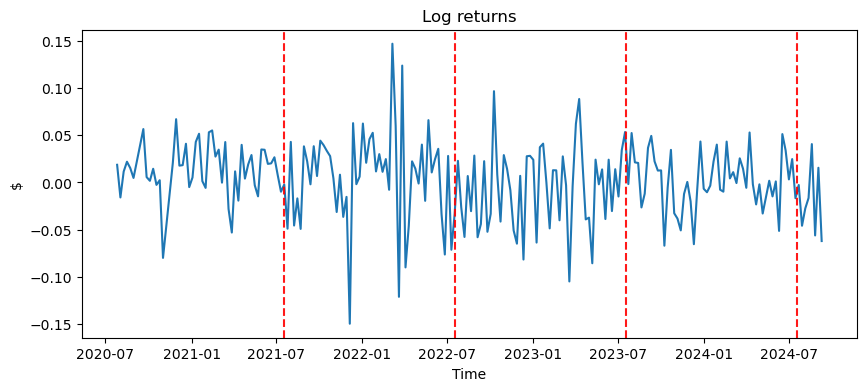

In [135]:
plt.figure(figsize=(10,4))
plt.plot(df['Log_Returns'])
plt.title('Log returns')
plt.xlabel('Time')
plt.ylabel('$')
for year in range(2021,2025):
    plt.axvline(pd.to_datetime(str(year)+'-07-18'),color='r', linestyle='--', alpha=0.9)
plt.show()

In [136]:
result = adfuller(df['Log_Returns'])
p_value = result[1]
formatted_p_value = "{:.2f}".format(p_value) #int 2 deicimal places
print("p-value:", formatted_p_value)

p-value: 0.00


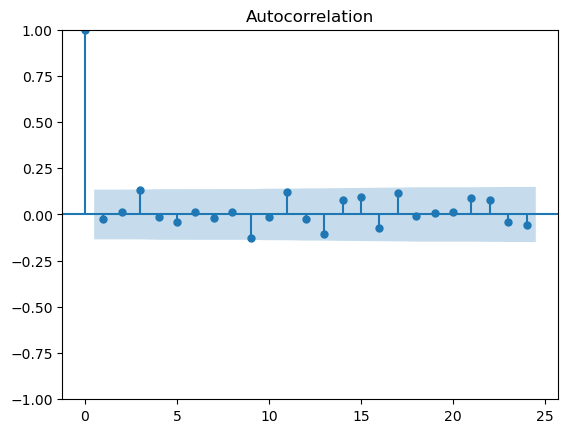

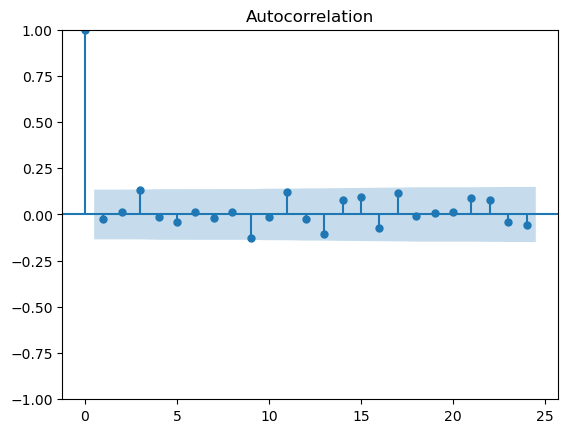

In [137]:
plot_acf(df['Log_Returns'])

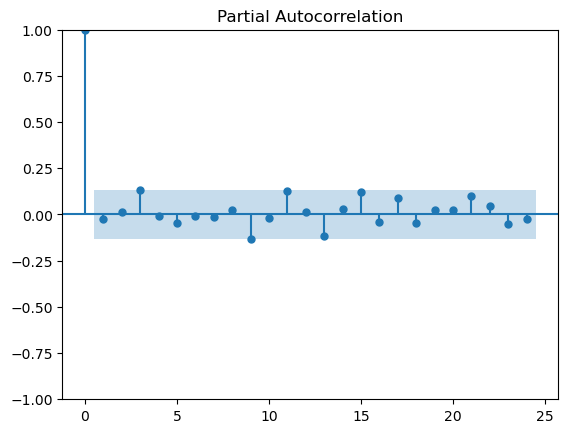

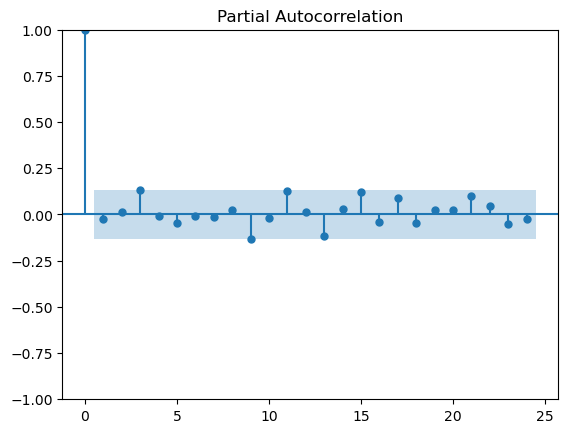

In [138]:
plot_pacf(df['Log_Returns'])

In [139]:
train_end = datetime(2024,5,31)

train_data = df['Log_Returns'][:train_end]
test_data = df[train_end + timedelta(days=1):]

In [140]:
model = arch_model(train_data, p=3, q=3)
model_fit = model.fit()
model_fit.summary()

Iteration:      1,   Func. Count:     10,   Neg. LLF: 2159.0139931741946
Iteration:      2,   Func. Count:     24,   Neg. LLF: 89.19605706593401
Iteration:      3,   Func. Count:     37,   Neg. LLF: -185.8329385618938
Iteration:      4,   Func. Count:     48,   Neg. LLF: -351.6181076825127
Iteration:      5,   Func. Count:     58,   Neg. LLF: -353.60304444239904
Iteration:      6,   Func. Count:     68,   Neg. LLF: -357.594641209245
Iteration:      7,   Func. Count:     77,   Neg. LLF: -357.54482570382623
Iteration:      8,   Func. Count:     88,   Neg. LLF: -351.5213418024846
Iteration:      9,   Func. Count:     99,   Neg. LLF: -358.15030910637506
Iteration:     10,   Func. Count:    109,   Neg. LLF: -358.37449494612076
Iteration:     11,   Func. Count:    118,   Neg. LLF: -358.3760929667836
Iteration:     12,   Func. Count:    128,   Neg. LLF: -358.38811017472096
Iteration:     13,   Func. Count:    137,   Neg. LLF: -358.3894921231033
Iteration:     14,   Func. Count:    146,   Neg.

c:\Users\Bogdan\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001642. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:            Log_Returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                358.390
Distribution:                  Normal   AIC:                          -700.779
Method:            Maximum Likelihood   BIC:                          -674.513
                                        No. Observations:                  197
Date:                Tue, Oct 01 2024   Df Residuals:                      196
Time:                        16:20:34   Df Model:                            1
                                  Mean Model                                 
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu         4.9062e-03  2.944e-03      1.667  9.558e-02 [-8.634e-04,1.068e-02]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega      1.3905e-04  1.508e-04      0.922      0.357 [-1.566e-04,4.347e-04]
alpha[1]       0.0175  3.697e-02      0.474      0.635 [-5.492e-02,9.000e-02]
alpha[2]       0.1125  5.344e-02      2.104  3.534e-02    [7.720e-03,  0.217]
alpha[3]       0.0000      0.108      0.000      1.000      [ -0.213,  0.213]
beta[1]    1.2345e-13      0.384  3.212e-13      1.000      [ -0.753,  0.753]
beta[2]        0.6007      0.109      5.494  3.929e-08      [  0.386,  0.815]
beta[3]        0.1885      0.230      0.819      0.413      [ -0.263,  0.640]
=============================================================================

Covariance estimator: robust
"""

In [141]:
rolling_predictions = pd.Series(index=test_data.index)

for i in test_data.index:
    train_data = df['Log_Returns'][:i - timedelta(days=1)]
    model = arch_model(train_data, p=3, q=3)
    model_fit = model.fit()
    predictions = model_fit.forecast(horizon=1)
    rolling_predictions.loc[i] = np.sqrt(predictions.variance.values[-1]) #the output of predictions is an array
    
rolling_predictions

c:\Users\Bogdan\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001642. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\Bogdan\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001634. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\Bogdan\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataS

Iteration:      1,   Func. Count:     10,   Neg. LLF: 2159.0139931741946
Iteration:      2,   Func. Count:     24,   Neg. LLF: 89.19605706593401
Iteration:      3,   Func. Count:     37,   Neg. LLF: -185.8329385618938
Iteration:      4,   Func. Count:     48,   Neg. LLF: -351.6181076825127
Iteration:      5,   Func. Count:     58,   Neg. LLF: -353.60304444239904
Iteration:      6,   Func. Count:     68,   Neg. LLF: -357.594641209245
Iteration:      7,   Func. Count:     77,   Neg. LLF: -357.54482570382623
Iteration:      8,   Func. Count:     88,   Neg. LLF: -351.5213418024846
Iteration:      9,   Func. Count:     99,   Neg. LLF: -358.15030910637506
Iteration:     10,   Func. Count:    109,   Neg. LLF: -358.37449494612076
Iteration:     11,   Func. Count:    118,   Neg. LLF: -358.3760929667836
Iteration:     12,   Func. Count:    128,   Neg. LLF: -358.38811017472096
Iteration:     13,   Func. Count:    137,   Neg. LLF: -358.3894921231033
Iteration:     14,   Func. Count:    146,   Neg.

c:\Users\Bogdan\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001644. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\Bogdan\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001641. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      8,   Func. Count:     88,   Neg. LLF: -353.5761662368011
Iteration:      9,   Func. Count:     99,   Neg. LLF: -361.6061574529363
Iteration:     10,   Func. Count:    109,   Neg. LLF: -361.8486476237702
Iteration:     11,   Func. Count:    118,   Neg. LLF: -361.850189484671
Iteration:     12,   Func. Count:    128,   Neg. LLF: -361.8595526000472
Iteration:     13,   Func. Count:    137,   Neg. LLF: -361.860799913283
Iteration:     14,   Func. Count:    146,   Neg. LLF: -361.8608094132228
Iteration:     15,   Func. Count:    154,   Neg. LLF: -361.8608094132108
Optimization terminated successfully    (Exit mode 0)
            Current function value: -361.8608094132228
            Iterations: 15
            Function evaluations: 154
            Gradient evaluations: 15
Iteration:      1,   Func. Count:     10,   Neg. LLF: 2039.7546104564856
Iteration:      2,   Func. Count:     24,   Neg. LLF: 108.937134547976
Iteration:      3,   Func. Count:     37,   Neg. LLF: -226.5800

c:\Users\Bogdan\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001633. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\Bogdan\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001627. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\Bogdan\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataS

Iteration:     12,   Func. Count:    125,   Neg. LLF: -372.3850030108929
Iteration:     13,   Func. Count:    134,   Neg. LLF: -372.3863003882891
Iteration:     14,   Func. Count:    143,   Neg. LLF: -372.38637227354275
Iteration:     15,   Func. Count:    152,   Neg. LLF: -372.38637495931135
Iteration:     16,   Func. Count:    160,   Neg. LLF: -372.38637495925417
Optimization terminated successfully    (Exit mode 0)
            Current function value: -372.38637495931135
            Iterations: 16
            Function evaluations: 160
            Gradient evaluations: 16
Iteration:      1,   Func. Count:     10,   Neg. LLF: 1953.8312331842908
Iteration:      2,   Func. Count:     24,   Neg. LLF: 114.99048040732598
Iteration:      3,   Func. Count:     37,   Neg. LLF: -218.36379814874215
Iteration:      4,   Func. Count:     48,   Neg. LLF: -360.58810405744157
Iteration:      5,   Func. Count:     58,   Neg. LLF: -369.7226528062323
Iteration:      6,   Func. Count:     68,   Neg. LLF:

c:\Users\Bogdan\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001613. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\Bogdan\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001617. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:     13,   Func. Count:    135,   Neg. LLF: -376.13916894173553
Iteration:     14,   Func. Count:    145,   Neg. LLF: -376.1392078641252
Iteration:     15,   Func. Count:    153,   Neg. LLF: -376.139207864305
Optimization terminated successfully    (Exit mode 0)
            Current function value: -376.1392078641252
            Iterations: 15
            Function evaluations: 153
            Gradient evaluations: 15
Iteration:      1,   Func. Count:     10,   Neg. LLF: 6649.0268573707845
Iteration:      2,   Func. Count:     24,   Neg. LLF: 46.5284924565013
Iteration:      3,   Func. Count:     37,   Neg. LLF: -231.79923532588896
Iteration:      4,   Func. Count:     48,   Neg. LLF: -364.90871700137393
Iteration:      5,   Func. Count:     58,   Neg. LLF: -373.1575708469295
Iteration:      6,   Func. Count:     68,   Neg. LLF: -377.7379061582093
Iteration:      7,   Func. Count:     77,   Neg. LLF: -375.5600050536102
Iteration:      8,   Func. Count:     87,   Neg. LLF: -360.

c:\Users\Bogdan\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001614. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\Bogdan\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001608. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\Bogdan\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataS

Iteration:      1,   Func. Count:     10,   Neg. LLF: 10341.694478195115
Iteration:      2,   Func. Count:     24,   Neg. LLF: 11.530022031227237
Iteration:      3,   Func. Count:     37,   Neg. LLF: -254.08970476858485
Iteration:      4,   Func. Count:     48,   Neg. LLF: -372.6349553628572
Iteration:      5,   Func. Count:     58,   Neg. LLF: -378.25353112696143
Iteration:      6,   Func. Count:     68,   Neg. LLF: -382.8064528380847
Iteration:      7,   Func. Count:     77,   Neg. LLF: -380.79418352628534
Iteration:      8,   Func. Count:     87,   Neg. LLF: -373.57350912071877
Iteration:      9,   Func. Count:     97,   Neg. LLF: -383.1250610153163
Iteration:     10,   Func. Count:    106,   Neg. LLF: -382.5668644575218
Iteration:     11,   Func. Count:    116,   Neg. LLF: -383.2049551646785
Iteration:     12,   Func. Count:    125,   Neg. LLF: -383.2075306586005
Iteration:     13,   Func. Count:    134,   Neg. LLF: -383.2077955783345
Iteration:     14,   Func. Count:    143,   Neg

c:\Users\Bogdan\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001609. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


DATE
2024-06-02    0.032174
2024-06-09    0.031238
2024-06-16    0.032102
2024-06-23    0.036808
2024-06-30    0.034935
2024-07-07    0.035160
2024-07-14    0.033588
2024-07-21    0.033961
2024-07-28    0.032975
2024-08-04    0.033316
2024-08-11    0.036152
2024-08-18    0.033571
2024-08-25    0.034731
2024-09-01    0.036042
2024-09-08    0.038276
dtype: float64

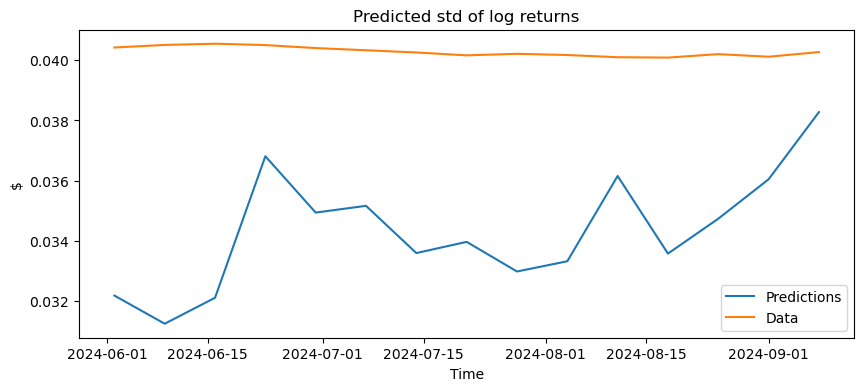

In [142]:
plt.figure(figsize=(10,4))
plt.plot(rolling_predictions, label='Predictions')
plt.plot(test_data['Std_Dev'], label='Data')
plt.title('Predicted std of log returns')
plt.ylabel('$')
plt.xlabel('Time')
plt.legend()

Text(0, 0.5, '$')

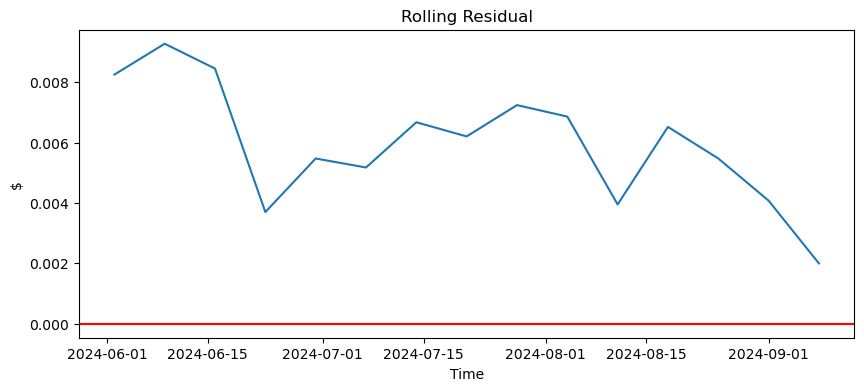

In [143]:
rolling_residual = test_data['Std_Dev'] - rolling_predictions

plt.figure(figsize=(10,4))
plt.plot(rolling_residual)
plt.axhline(y=0, color = 'r')
plt.title('Rolling Residual')
plt.xlabel('Time')
plt.ylabel('$')

In [144]:
print('Mean abs % error:',np.mean(abs(rolling_residual/test_data['Std_Dev'])))

Mean abs % error: 0.1477179489333949


In [145]:
print('Root mean squared error:',np.sqrt(np.mean(rolling_residual**2)))

Root mean squared error: 0.006255571473857889
